In [19]:
# 首先导入本节需要的包或模块。
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

batch_size=256
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = tf.cast(x_train, tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
x_test = tf.cast(x_test,tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
train_iter = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_iter = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [20]:
# 初始化模型参数
num_inputs = 784
num_outputs = 10
W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs), mean=0, stddev=0.01, dtype=tf.float32))
b = tf.Variable(tf.zeros(num_outputs, dtype=tf.float32))

In [30]:
X = tf.constant([
 [[1, 2, 3, 4],
  [5, 6, 7, 8],
  [9, 10, 11, 12]],
 [[13, 14, 15, 16],
  [17, 18, 19, 20],
  [21, 22, 23, 24]]])
tf.reduce_sum(X, axis=2, keepdims=True)

<tf.Tensor: id=551, shape=(2, 3, 1), dtype=int32, numpy=
array([[[10],
        [26],
        [42]],

       [[58],
        [74],
        [90]]])>

In [31]:
# 定义softmax
def softmax(logits, axis=-1):
    return tf.exp(logits)/tf.reduce_sum(tf.exp(logits), axis, keepdims=True)

In [32]:
# 定义模型
def net(X):
    logits = tf.matmul(tf.reshape(X, shape=(-1, W.shape[0])), W) + b
    return softmax(logits)

In [33]:
# 定义交叉熵损失函数
def cross_entropy(y_hat, y):
    y = tf.cast(tf.reshape(y, shape=[-1, 1]),dtype=tf.int32)
    # one_hot https://blog.csdn.net/nini_coded/article/details/79250600
    y = tf.one_hot(y, depth=y_hat.shape[-1])
    y = tf.cast(tf.reshape(y, shape=[-1, y_hat.shape[-1]]),dtype=tf.int32)
    # boolean_mask 通过boolean过滤元素
    return -tf.math.log(tf.boolean_mask(y_hat, y)+1e-8)

In [34]:
# 计算分类准去率
def accuracy(y_hat, y):
    return np.mean((tf.argmax(y_hat, axis=1) == y))

In [35]:
# 描述,对于tensorflow2中，比较的双方必须类型都是int型，所以要将输出和标签都转为int型
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for _, (X, y) in enumerate(data_iter):
        y = tf.cast(y,dtype=tf.int64)
        acc_sum += np.sum(tf.cast(tf.argmax(net(X), axis=1), dtype=tf.int64) == y)
        n += y.shape[0]
    return acc_sum / n

print(evaluate_accuracy(test_iter, net))

0.1027


In [36]:
num_epochs, lr = 5, 0.1
# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = tf.reduce_sum(loss(y_hat, y))
            grads = tape.gradient(l, params)
            if trainer is None:
                # 如果没有传入优化器，则使用原先编写的小批量随机梯度下降
                for i, param in enumerate(params):
                    param.assign_sub(lr * grads[i] / batch_size)
            else:
                # tf.keras.optimizers.SGD 直接使用是随机梯度下降 theta(t+1) = theta(t) - learning_rate * gradient
                # 这里使用批量梯度下降，需要对梯度除以 batch_size, 对应原书代码的 trainer.step(batch_size)
                trainer.apply_gradients(zip([grad / batch_size for grad in grads], params))  

            y = tf.cast(y, dtype=tf.float32)
            train_l_sum += l.numpy()
            train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_hat, axis=1) == tf.cast(y, dtype=tf.int64), dtype=tf.int64)).numpy()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

trainer = tf.keras.optimizers.SGD(lr)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

Instructions for updating:
Use tf.identity instead.
epoch 1, loss 0.7837, train acc 0.750, test acc 0.794
epoch 2, loss 0.5707, train acc 0.813, test acc 0.813
epoch 3, loss 0.5256, train acc 0.825, test acc 0.820
epoch 4, loss 0.5014, train acc 0.832, test acc 0.825
epoch 5, loss 0.4856, train acc 0.837, test acc 0.828


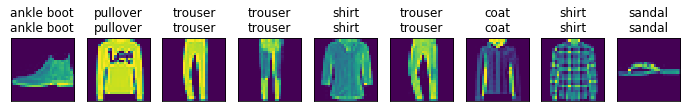

In [37]:
import matplotlib.pyplot as plt
X, y = iter(test_iter).next()

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    # 这⾥的_表示我们忽略（不使⽤）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12)) # 这里注意subplot 和subplots 的区别
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(tf.reshape(img, shape=(28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(tf.argmax(net(X), axis=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])
